In [1]:
import importlib
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import swifter  # noqa: F401

from stk_search.geom3d import train_models
from stk_search.ObjectiveFunctions.ObjectiveFunction import LookUpTable
from stk_search.Representation import (
    Representation_from_fragment,
)
from stk_search.Search_algorithm import (
    BayesianOptimisation,
    Ea_surrogate,
    Search_algorithm,
)

Path("search_experiment/search_exp_database").mkdir(
    parents=True, exist_ok=True
)


In [22]:
# load Search space and check conditions

SearchSpace_loc = "/media/mohammed/Work/STK_search/Example_notebooks/SearchSpace/SearchSpace_test.pkl"

with Path(SearchSpace_loc).open("rb") as f:
    sp = pickle.load(f)  # noqa: , S301,
sp.update()
print(sp.syntax)
print(sp.conditions_list)
print(f"size of the search space is : {sp.get_space_size():.2e}")
sp.df_precursors.head()

[0, 1, 2, 3, 4, 5]
[[], [], [], [], [], []]
size of the search space is : 8.37e+14


,electron affinity (eV),homo lumo_gap (eV),ionisation potential (eV),total energy (au),HOMO-LUMO GAP (eV),ES1,fosc1,InChIKey,mol_opt,Atom_num
0,3.0685,0.095166,9.1140,-56.555859,1.672081,3.787,0.0003,GVYASUPVXDSGHN-UQCOIBPSSA-N,<rdkit.Chem.rdchem.Mol object at 0x706d2f0bc3b0>,22
1,2.8466,0.038435,9.3325,-56.536670,2.258122,3.514,0.0016,HNRHIGPDSSXEJA-FARCUNLSSA-N,<rdkit.Chem.rdchem.Mol object at 0x706d2f0bc360>,22
2,2.9365,0.072094,9.2252,-56.533763,2.009171,3.414,0.0003,SNMJIXVGAOBXCS-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x706d2f0bc400>,22
3,2.5901,0.064465,8.9842,-48.098467,2.153852,3.364,0.0008,LWMBLJLODRWDDF-NYYWCZLTSA-N,<rdkit.Chem.rdchem.Mol object at 0x706d2f0bc450>,22
4,2.5596,0.076792,8.8405,-48.091982,1.967541,3.342,0.0004,BJFIUKSBVAJFOJ-WTKPLQERSA-N,<rdkit.Chem.rdchem.Mol object at 0x706d2f0bc4a0>,22


In [23]:
df_total_path = "/media/mohammed/Work/STK_search/Example_notebooks/data_example/Molecule_database/30K_benchmark_150524.csv"
df_total = pd.read_csv(df_total_path)
oligomer_size = 6
target_name = "target"
aim = "maximise"
df_total["target"] = (
    -np.abs(df_total["ES1"] - 3)
    - np.abs(df_total["ionisation potential (eV)"] - 5.5)
    + np.log10(df_total["fosc1"])
)
df_total.to_csv(df_total_path, index=False)
# define the evaluation function
ObjectiveFunction = LookUpTable(
    df_total, oligomer_size, target_name=target_name, aim=aim
)

In [24]:
# initialise search algorithm

which_acquisition = "EI"
lim_counter = 10
BO_learned = BayesianOptimisation.BayesianOptimisation(
    which_acquisition=which_acquisition, lim_counter=lim_counter
)
EA = Search_algorithm.evolution_algorithm()

BO_Mord = BayesianOptimisation.BayesianOptimisation(
    which_acquisition=which_acquisition, lim_counter=lim_counter
)
BO_Prop = BayesianOptimisation.BayesianOptimisation(
    which_acquisition=which_acquisition, lim_counter=lim_counter
)


In [25]:
# load the Representation and the model

config_dir = "/media/mohammed/Work/STK_search/Example_notebooks/data_example/representation_learning/splitrand-nummol20000/"
config, min_val_loss = train_models.get_best_embedding_model(config_dir)
BO_learned.config_dir = config_dir
BO_learned.load_representation_model()


Model loaded:  SchNet


(<stk_search.Representation.Representation_poly_3d.RepresentationPoly3d at 0x706d3f6cf070>,
 Pymodel_new(
   (molecule_3D_repr): SchNet(hidden_channels=128, num_filters=128, num_interactions=8, num_gaussians=51, cutoff=6)
   (graph_pred_linear): Linear(in_features=128, out_features=1, bias=True)
   (transform_to_opt): Linear(in_features=128, out_features=128, bias=True)
 ))

In [173]:
# initialise the Representation of the molecules used
# here we use the dataframe of the precursors that has PCA of desrciprtors calculated using mordred

df_representation_path = "/media/mohammed/Work/STK_search/Example_notebooks/data_example/precursor/df_mordred_24072024.pkl"
df_representation = pd.read_pickle(df_representation_path)  # noqa: S301
df_representation = df_representation.dropna(axis=1)
# check if the Representation dataframe contains all the elements in teh search space
frag_properties = df_representation.select_dtypes(include=[np.number]).columns
print(frag_properties)
BO_Mord.Representation = (
    Representation_from_fragment.RepresentationFromFragment(
        df_representation, frag_properties
    )
)



Index(['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7',
       'PCA_8', 'PCA_9'],
      dtype='object')


In [132]:
# initialise the Representation of the molecules used
# here we use the dataframe of the precursors that has PCA of desrciprtors calculated using mordred

df_representation_path = "/media/mohammed/Work/STK_search/Example_notebooks/data_example/precursor/df_properties.pkl"
df_representation = pd.read_pickle(df_representation_path)  # noqa: S301
df_representation = df_representation.dropna(axis=1)
# check if the Representation dataframe contains all the elements in teh search space
frag_properties = df_representation.select_dtypes(include=[np.number]).columns
print(frag_properties)
BO_Prop.Representation = (
    Representation_from_fragment.RepresentationFromFragment(
        df_representation, frag_properties
    )
)



Index(['electron affinity (eV)', 'homo lumo_gap (eV)',
       'ionisation potential (eV)', 'total energy (au)', 'HOMO-LUMO GAP (eV)',
       'ES1', 'fosc1', 'Atom_num'],
      dtype='object')


In [163]:
from sklearn.decomposition import PCA, KernelPCA, FastICA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def get_repr(df_total, Representation):
    df_rep = df_total.copy()
    pca_kernel = PCA(n_components=5,whiten=True)
    Xrep= Representation.generate_repr(df_rep[[f'InChIKey_{i}' for i in range(6)]]).cpu().detach().numpy()    
    pca_result = pca_kernel.fit_transform(Xrep)
    df_rep['PCA1'] = pca_result[:,0]
    df_rep['PCA2'] = pca_result[:,1]
    return df_rep

In [124]:
num_mol = 15000
df_total = sp.check_df_for_element_from_sp(df_total)
df_plot = df_total.sample(num_mol)
learned_repr = get_repr(df_plot, BO_learned.Representation)



KeyboardInterrupt: 

array([[<Axes: title={'center': 'PCA1'}>]], dtype=object)

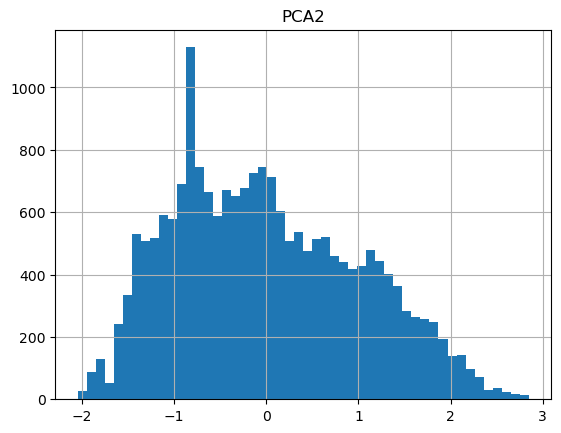

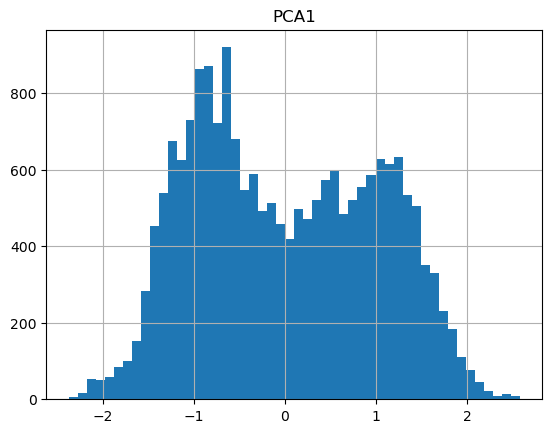

In [174]:
df_plot = df_total.sample(20000)
prop_repr = get_repr(df_plot, BO_Prop.Representation)
#elimenate outliers
mord_repr = get_repr(df_plot, BO_Mord.Representation)

#mord_repr = mord_repr[(mord_repr['PCA2']<-2.23e5) & (mord_repr['PCA2']>-2.25e5)& (mord_repr['PCA1']>-9.45e5)& (mord_repr['PCA1']<-9.4e5)]
mord_repr.hist(column='PCA2', bins=50)
mord_repr.hist(column='PCA1', bins=50)


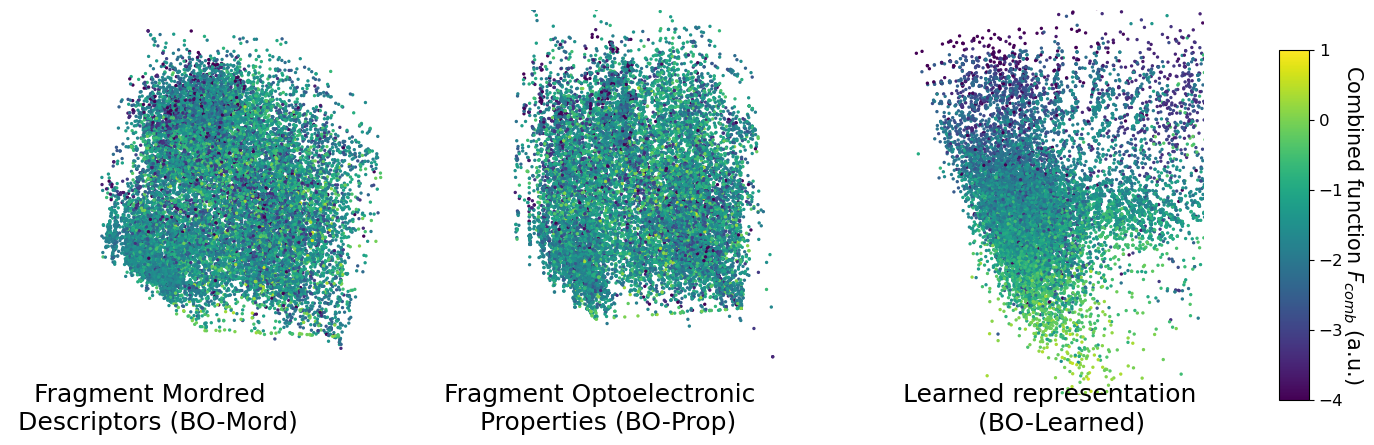

In [175]:
from matplotlib import pyplot as plt
%matplotlib inline
fig,ax=plt.subplots(1,3,figsize=(15,5))
ax = ax.flatten()
for i,df in enumerate([mord_repr,prop_repr,learned_repr]):
    cmap = ax[i].scatter(df['PCA2'],df['PCA1'],s=2,c=df['target'],label='learned representation',vmin=-4,vmax =1)
    ax[i].set_xlim(df['PCA2'].median()- 3* df['PCA2'].std(),df['PCA2'].median()+3 * df['PCA2'].std())
    ax[i].set_ylim(df['PCA1'].median()- 3 * df['PCA1'].std(),df['PCA1'].median()+3 * df['PCA1'].std())
    ax[i].set_axis_off()
fig.subplots_adjust(right=0.9)  # leave some space for the colorbar
#ax[0].set_title('Fragment Mordred \n Descriptors', fontsize=15,visible=True,loc='bottom')
fig.text(0.2, 0.04, 'Fragment Mordred \n Descriptors (BO-Mord)', fontsize=18,ha='center')
fig.text(0.5, 0.04, 'Fragment Optoelectronic \n Properties (BO-Prop)', fontsize=18,ha='center')
fig.text(0.8, 0.04, 'Learned representation \n  (BO-Learned)', fontsize=18,ha='center')
# Create a new axes for the colorbar
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.7])

# Add the colorbar to the new axes
cbar = fig.colorbar(cmap, cax=cbar_ax,label='target')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Combined function $F_{comb}$ (a.u.)', rotation=270, labelpad=15, fontsize=15)



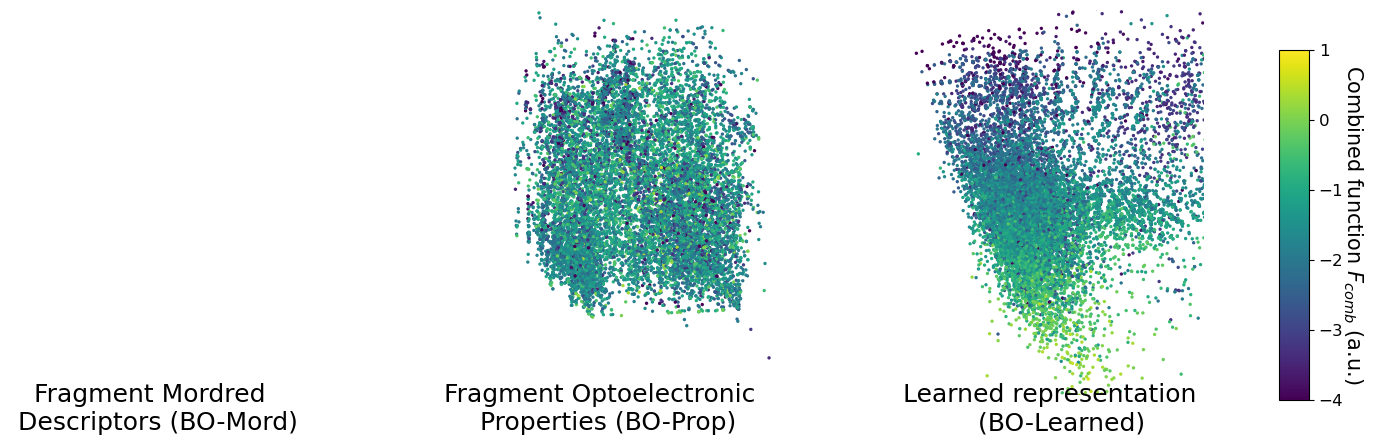

In [162]:
ax[0].set_ylim(ax[0].get_ylim()[0]/5,ax[0].get_ylim()[1]/5)
ax[0].set_xlim(ax[0].get_xlim()[0]/5,ax[0].get_xlim()[1]/5)
fig